In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st

# Анализ успешности игр

Доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные до 2016 года. 

In [3]:
df = pd.read_csv('/datasets/games.csv')

## Обзор данных

In [4]:
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

array([[<AxesSubplot:title={'center':'Year_of_Release'}>,
        <AxesSubplot:title={'center':'NA_sales'}>],
       [<AxesSubplot:title={'center':'EU_sales'}>,
        <AxesSubplot:title={'center':'JP_sales'}>],
       [<AxesSubplot:title={'center':'Other_sales'}>,
        <AxesSubplot:title={'center':'Critic_Score'}>]], dtype=object)

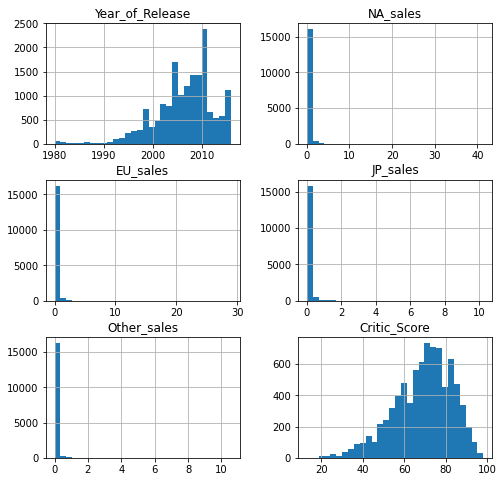

In [7]:
df.hist(figsize = (8,8), bins = 30)

<AxesSubplot:ylabel='Platform'>

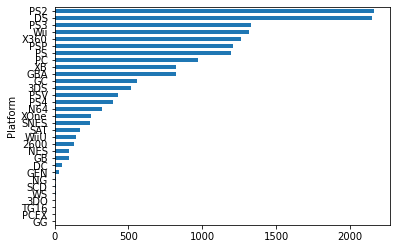

In [8]:
df.groupby('Platform')['Platform'].count().sort_values().plot.barh()

<AxesSubplot:ylabel='Genre'>

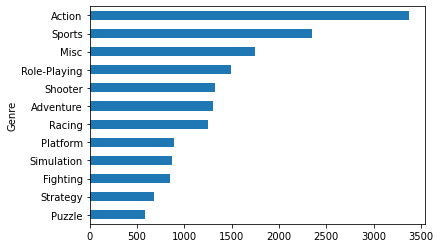

In [9]:
df.groupby('Genre')['Genre'].count().sort_values().plot.barh()

<AxesSubplot:ylabel='Rating'>

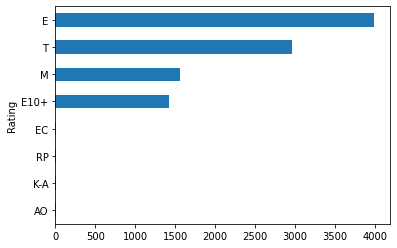

In [10]:
df.groupby('Rating')['Rating'].count().sort_values().plot.barh()

<AxesSubplot:>

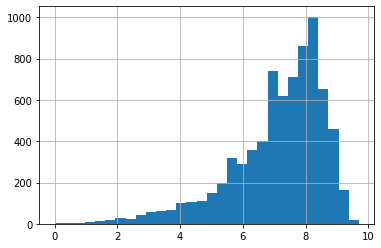

In [11]:
df.query('User_Score != "tbd"')['User_Score'].astype(float).hist(bins = 30)

**Вывод**

1. Есть пропущенные значения в столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating`

2. Присутствуеют аномальные значения по всех столбцах с продажами, а так же в столбце `Rating`

3. В столбце `Critic_Score` распределение близко к нормальному

4. В столбце `User_Score` данные имеют Пуассоновское распределение

## Предобработка данных


### Преобразование типов

- Приведем все столбцы к нижнему регистру.
- Столбец `User_Score` приведем к `float` формату, все tbd значения станут NaN, что никак не исказит данные

In [12]:
df.columns = df.columns.str.lower()

In [13]:
df['user_score'] = df.query('user_score != "tbd"')['user_score'].astype(float)

### Столбец `Name`

**Исключим все пропущенные записи, т.к их невозможно идентифицировать, возможная причина пропусков : ошибка при сборе данных**


In [14]:
df = df.dropna(subset = ['name'])

In [15]:
df.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

### Столбец `Year_of_Release`


In [16]:
df['year_of_release'].isna().sum() / df.shape[0]

0.016095255190570215

**Пропуски состявляют 1.6% процента, поэтому удалим их. Возможная причина пропусков : недоступность информации на момент сбора данных, ошибки при сборе или обработке данных**

In [17]:
df = df.dropna(subset = ['year_of_release'])

### Столбцы `Critic_Score`, `User_Score`


In [18]:
df['critic_score'].isna().sum() / df.shape[0]

0.5145341765993675

In [19]:
df['user_score'].isna().sum() / df.shape[0]

0.5461566528825104

**Пропуски составляют более половины данных. Оставим пропуски без изменений, чтобы не исказить данные, так же учтем что есть значение `tbd`, что означает, что данных было еще недостаточно для выставления оценки.**

`Critic_Score` возможные причины пропусков : для некоторых игр критики еще не дали своих оценок на момент сбора данных. Некоторые игры могут быть недостаточно популярны или новы, чтобы привлечь внимание критиков.

`User_Score` возможные причины пропусков : ошибка при получении данных, недостаток оценок.

### Столбец `Rating`

In [20]:
df['rating'].isna().sum() / df.shape[0]

0.40598394551204087

**Пропуски составляют 40% данных, оставим их без изменений. Возможная причина: малопопулярная игра, оринтируется на локальную аудиторию.**

**Добавим столбец суммарный плодаж**

In [21]:
df['total_sales'] = (df['na_sales'] +
                     df['eu_sales'] +
                     df['jp_sales'] +
                     df['other_sales'])

In [22]:
df.duplicated().sum()

0

**Явных дубликатов нет**

**Вывод:**

1. Столбец `Name` исключили пропущенные значения, невозможно идентифицировать

2. Столбец `Year_of_Release` удалили пропуски, потеря данных 1.6%

3. Столбцы `Critic_Score`, `User_Score` оставили без изменения, возможные причины: малая популярность игры, ошибки при сборе данных

4. Столбец `Rating` оставили без изменений, возможные причины: ориентацию на локальную аудиторию, низкая популярность

5. `tbd` в столбце `User_Score` обозначает, что оценка еще не известна

6. Явных дубликатов нет

## Исследовательский анализ данных

### Распределение выхода игр

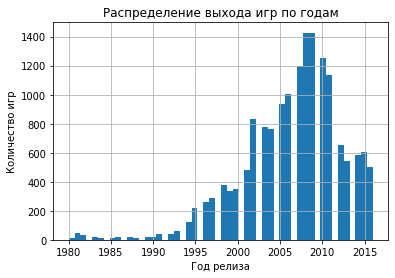

In [23]:
df['year_of_release'].plot(kind = 'hist',
                           bins = df['year_of_release'].nunique()+15,
                           grid = True)
plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.title('Распределение выхода игр по годам')
plt.show()

In [24]:
df['year_of_release'].quantile(0.04)

1995.0

**4% процентиль 1995 год, так же по гистограмме видно что данные до 1995 очень мало, поэтому оставим данные с 1995 по 2016**

In [25]:
df = df.query('year_of_release >= 1995')

### Изменение продаж по платформам


In [26]:
most_popular_platform = (df.groupby('platform')['total_sales']
 .sum()
 .sort_values(ascending = False)
)
most_popular_platform

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       721.55
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
XB       251.57
PC       239.79
N64      218.01
GC       196.73
XOne     159.32
GB       139.90
WiiU      82.19
PSV       53.81
SNES      49.59
SAT       29.94
DC        15.95
WS         1.42
NG         0.43
TG16       0.16
3DO        0.08
PCFX       0.03
Name: total_sales, dtype: float64

**Возьмем как самые популярные платформы от PS2 до PS, т.к дальше платформы очень непопулярны**

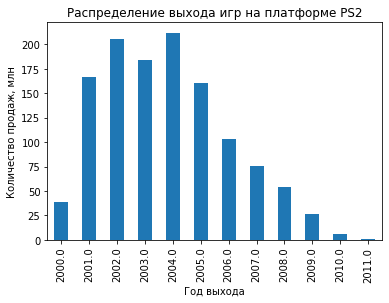

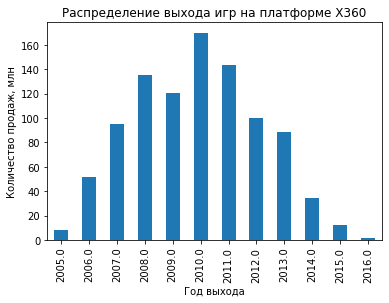

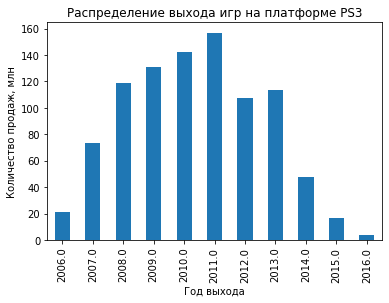

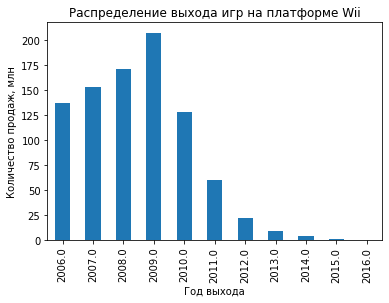

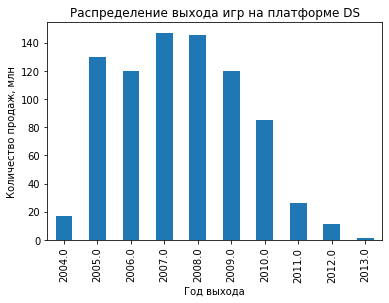

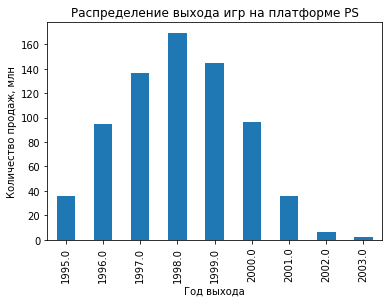

In [27]:
for platform in most_popular_platform[:6].index:
    (df.query('platform in @platform').groupby('year_of_release')['total_sales']
     .sum()
     .plot(kind = 'bar'))
    plt.xlabel('Год выхода')
    plt.ylabel('Количество продаж, млн')
    plt.title(f'Распределение выхода игр на платформе {platform}')
    plt.show()

1. PS2 - временной интервал 2000-2011, в 2011 продаж уже очень мало, платформа устарела

2. X360 - временной интервал 2005-2016, в 2016 продаж очень мало, но платформа актуальна

3. PS3 - временной интервал 2006-2016, по сей день продажи есть, но пик популярности прошел

4. Wii - временной интервал 2006-2015, в 2014, 2015 годах продаж очень мало, платформа устарела

5. DS - временной интервал 2004-2013, в 2013 продаж очень мало, платформа устарела

6. PS - временной интервал 1994-2003, в 2003 продаж мало, платформа устарела


- В среднем жизненный цикл платформы 10 лет
- Актуальный период будем считать 2012-2016, т.к с 2000 до 2010 был огромный пик, а после падение, после которого продажи игр более менее стабилизировались на одном уровне

In [28]:
df = df.query('year_of_release >= 2012')

In [29]:
(df.groupby('platform')['total_sales']
 .sum()
 .sort_values(ascending = False)
)

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64

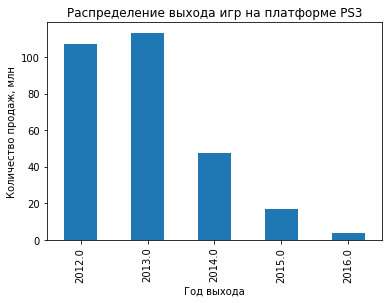

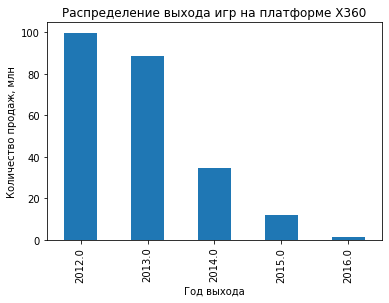

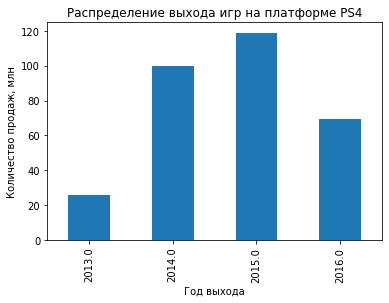

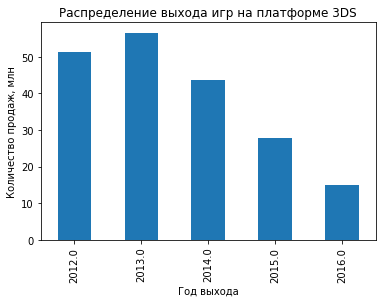

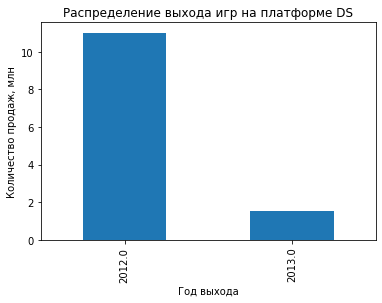

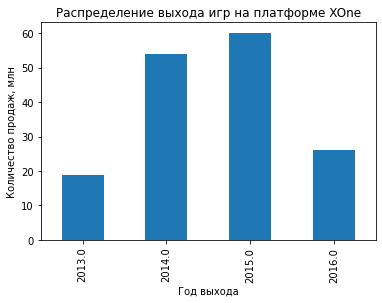

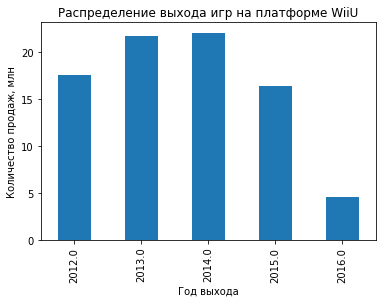

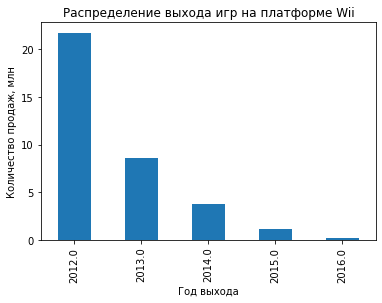

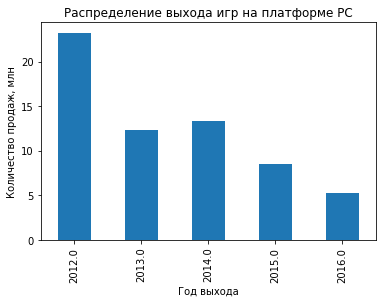

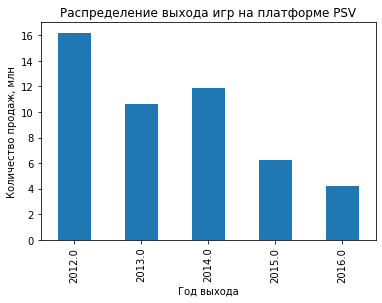

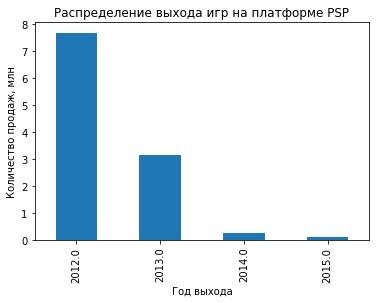

In [30]:
for platform in df['platform'].unique():
    (df.query('platform in @platform').groupby('year_of_release')['total_sales']
     .sum()
     .plot(kind = 'bar'))
    plt.xlabel('Год выхода')
    plt.ylabel('Количество продаж, млн')
    plt.title(f'Распределение выхода игр на платформе {platform}')
    plt.show()

**Лидируют по продажам: PS3, X360, 3DS, XOne**

**Все платформы падают**

**Потенциально прибыльные: PS4, 3DS, XOne, PC**

Text(0.5, 1.0, 'Количество продаж по платформам')

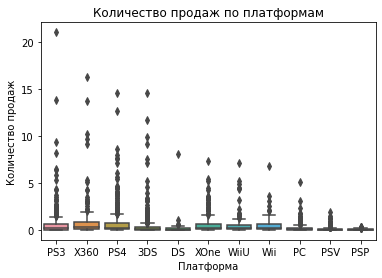

In [31]:
sns.boxplot(x = 'platform', y = 'total_sales', data = df)
plt.xlabel('Платформа')
plt.ylabel('Количество продаж')
plt.title('Количество продаж по платформам')

**Данные выглядят очень разбросано, сделаем ограничение по оси Y**

(0.0, 3.0)

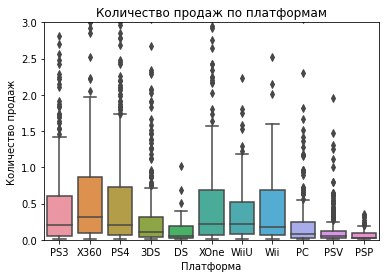

In [32]:
sns.boxplot(x = df['platform'], y = (df['total_sales']))
plt.xlabel('Платформа')
plt.ylabel('Количество продаж')
plt.title('Количество продаж по платформам')
plt.ylim([0,3])

**Заметно что самые популярные платформы X360, PS3, PS4, XOne, Wii. Самые непопулярные PSP, PSV**

**Самые большие выбросы от 3 квантиля в 3DS, PSV**

**Выбросы могут свидетельствовать о том, что некоторые игры или платформы были особенно успешными. Например, могли появиться очень популярные игры, которые привели к резкому увеличению продаж на определенных платформах**

**Медианы близко смещены к нижнем квартилям скорее всего потому что:**

Большинство игр имеют низкие объемы продаж: Поскольку медиана близка к нижнему квартилю, это означает, что большая часть игр продается не очень хорошо.

Некоторые игры очень популярны: Скошенность распределения вправо говорит о наличии небольшого числа игр с очень высокими продажами, которые создают "длинный хвост" в данных.

Успех некоторых игр может быть скорее исключением, чем правилом, и стоит учитывать эту информацию при прогнозировании будущих продаж.

### Влияние оценок на популярность платформ

array([[<AxesSubplot:xlabel='total_sales', ylabel='total_sales'>,
        <AxesSubplot:xlabel='critic_score', ylabel='total_sales'>,
        <AxesSubplot:xlabel='user_score', ylabel='total_sales'>],
       [<AxesSubplot:xlabel='total_sales', ylabel='critic_score'>,
        <AxesSubplot:xlabel='critic_score', ylabel='critic_score'>,
        <AxesSubplot:xlabel='user_score', ylabel='critic_score'>],
       [<AxesSubplot:xlabel='total_sales', ylabel='user_score'>,
        <AxesSubplot:xlabel='critic_score', ylabel='user_score'>,
        <AxesSubplot:xlabel='user_score', ylabel='user_score'>]],
      dtype=object)

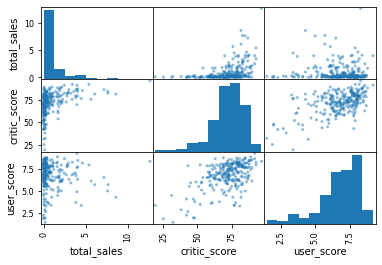

In [33]:
pd.plotting.scatter_matrix(df.query('platform == "PS4"')[['total_sales','critic_score','user_score']].dropna())

In [34]:
df.query('platform == "PS4"')[['total_sales','critic_score','user_score']].dropna().corr()['total_sales'][1:]

critic_score    0.405895
user_score     -0.033625
Name: total_sales, dtype: float64

**На основе самой популярной платформы можно сделать вывод что оценки критиков и количество продаж имеют умеременную зависимость, а вот оценки пользователей никак не влияют на количество продаж игры**

In [35]:
for platform in df['platform'].unique():
    print('Платформа:', platform)
    print(df.query('platform == @platform')
          [['total_sales','critic_score','user_score']]
          .corr()
          .loc['total_sales'][1:])

Платформа: PS3
critic_score    0.331497
user_score     -0.005144
Name: total_sales, dtype: float64
Платформа: X360
critic_score    0.360573
user_score      0.006164
Name: total_sales, dtype: float64
Платформа: PS4
critic_score    0.406568
user_score     -0.031957
Name: total_sales, dtype: float64
Платформа: 3DS
critic_score    0.320803
user_score      0.197583
Name: total_sales, dtype: float64
Платформа: DS
critic_score         NaN
user_score      0.882709
Name: total_sales, dtype: float64
Платформа: XOne
critic_score    0.416998
user_score     -0.068925
Name: total_sales, dtype: float64
Платформа: WiiU
critic_score    0.348380
user_score      0.400219
Name: total_sales, dtype: float64
Платформа: Wii
critic_score   -0.424341
user_score      0.296197
Name: total_sales, dtype: float64
Платформа: PC
critic_score    0.237243
user_score     -0.121867
Name: total_sales, dtype: float64
Платформа: PSV
critic_score    0.094488
user_score     -0.004339
Name: total_sales, dtype: float64
Платформа

**Сразу заметен один интересный факт. Там где оценки критиков неизвестны, корреляция с пользовательскими оценками высокая (платформы DS, PSP).**

**Умеренная зависимость продаж и оценок критиков наблюдается почти на всех платформах, за исключением PC (низкая зависимость) и PSV(отсутствует зависимость)**



**Умеренная зависимость продаж и оценок пользователей у платформ WiiU, Wii**

**На остальных платформах пользовательская оценка почти никак не влияет на количество продаж**


**Платформа PSV сильно выделяет среди остальных, т.к у нее нет никакой корреляции ни с пользовательскими оценками, ни с оценками критиков**

**Вывод: большая часть платформ имеет умеренную зависимость продаж с оценками критиков, и не имеет зависимости продаж с оценками пользователей** 

### Популярность игр по жанрам

In [36]:
df.groupby('genre')['total_sales'].mean().sort_values(ascending = False)

genre
Shooter         1.296723
Platform        0.717647
Sports          0.675634
Role-Playing    0.521081
Racing          0.465217
Misc            0.442917
Simulation      0.439000
Action          0.427856
Fighting        0.408165
Strategy        0.187887
Puzzle          0.174643
Adventure       0.097450
Name: total_sales, dtype: float64

In [37]:
df.groupby('genre')['total_sales'].sum().sort_values(ascending = False)

genre
Action          441.12
Shooter         304.73
Role-Playing    192.80
Sports          181.07
Misc             85.04
Platform         61.00
Racing           53.50
Fighting         44.49
Simulation       35.12
Adventure        29.43
Strategy         13.34
Puzzle            4.89
Name: total_sales, dtype: float64

**Самые популярные жанры `Action`, `Shooter`, `Role-Playing`, `Sports`, самые непопулярные `Puzzle`, `Strategy`**

**Потенциально прибыльные жанры `Shooter`, `Platform`, `Sports`, остальные менее прибыльны**

**Вывод:**


- Потенциально прибыльные  платформы: X360, PS3, PS4, XOne, Wii

- На большинстве платформ оценки критиков и продажи имеют умеренную зависимость, тогда как оценки пользователей не влияют на количество продаж

- Самые популярные жанры `Action`, `Shooter`, `Role-Playing`, `Sports`, самые непопулярные `Puzzle`, `Strategy`

- Потенциально прибыльные жанры `Shooter`, `Platform`, `Sports`, остальные менее прибыльны

## Портрет пользователя каждого региона

### Популярные платформы

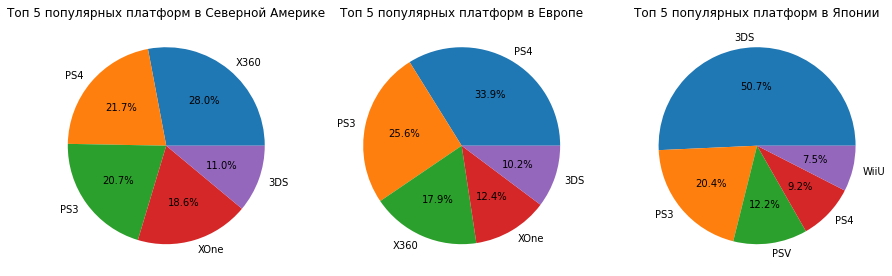

In [38]:
figure, top_platform = plt.subplots(1,3)
df.groupby('platform')['na_sales'].sum().sort_values(ascending = False)[:5].plot(
    kind = 'pie',
    autopct='%1.1f%%',
    figsize = (15,15),
    ylabel = '',
    ax = top_platform[0],
    title = 'Топ 5 популярных платформ в Северной Америке')

df.groupby('platform')['eu_sales'].sum().sort_values(ascending = False)[:5].plot(
    kind = 'pie',
    autopct='%1.1f%%',
    ylabel = '',
    ax = top_platform[1],
    title = 'Топ 5 популярных платформ в Европе')

df.groupby('platform')['jp_sales'].sum().sort_values(ascending = False)[:5].plot(
    kind = 'pie',
    autopct='%1.1f%%',
    
    ylabel = '',
    ax = top_platform[2],
    title = 'Топ 5 популярных платформ в Японии')

plt.show()

**В NA самые популярные платформы  X360, PS4, PS3, самая непопулярная 3DS. Причина популярности: активное продвижение платформ в данном регионе**

**В EU самые популярные PS4, PS3, X360, самая непопулярная 3DS. Причина популярности : активное продвижение платформ в данном регионе**

**В JP самая популярная 3DS, самые непопулярные WiiU, PS4. Причина аналогична предыдущим, 3DS скорее всего активно продвигается в Японии**

**Так же возможной причиной может служить жанровость игр для платформ**

### Популярные жанры

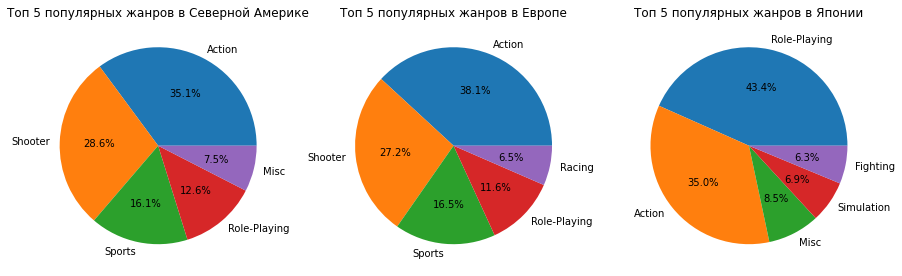

In [39]:
figure, top_genre = plt.subplots(1,3)
df.groupby('genre')['na_sales'].sum().sort_values(ascending = False)[:5].plot(
    kind = 'pie',
    autopct='%1.1f%%',
    figsize = (15,15),
    ylabel = '',
    ax = top_genre[0],
    title = 'Топ 5 популярных жанров в Северной Америке')

df.groupby('genre')['eu_sales'].sum().sort_values(ascending = False)[:5].plot(
    kind = 'pie',
    autopct='%1.1f%%',
    ylabel = '',
    ax = top_genre[1],
    title = 'Топ 5 популярных жанров в Европе')

df.groupby('genre')['jp_sales'].sum().sort_values(ascending = False)[:5].plot(
    kind = 'pie',
    autopct='%1.1f%%',
    
    ylabel = '',
    ax = top_genre[2],
    title = 'Топ 5 популярных жанров в Японии')

plt.show()

**В Северной Америке и Европе самые популярные Action, Sports, Shooter, а самые непопулярные Misc, Racing, Role-Playing**

**В Японии с огромным процентом лидирует Role-Playing, а самые непопулярные жанры Fighting, Simulation**

**Так же причиной можежт быть предпочтения целевой аудитории в разных регионах**

### Рейтинг ESRB

**Заменим пропущенные значения значением NR(не указано)**

In [40]:
df['rating'] = df['rating'].fillna('NR')

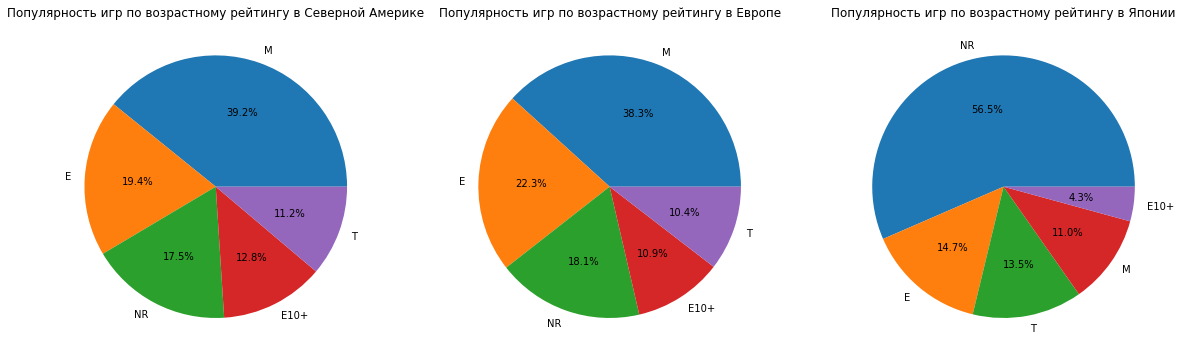

In [41]:
figure, ratings = plt.subplots(1,3)
df.groupby('rating')['na_sales'].sum().sort_values(ascending = False)[:5].plot(
    kind = 'pie',
    autopct='%1.1f%%',
    figsize = (20,20),
    ylabel = '',
    ax = ratings[0],
    title = 'Популярность игр по возрастному рейтингу в Северной Америке')

df.groupby('rating')['eu_sales'].sum().sort_values(ascending = False).plot(
    kind = 'pie',
    autopct='%1.1f%%',
    ylabel = '',
    ax = ratings[1],
    title = 'Популярность игр по возрастному рейтингу в Европе')

df.groupby('rating')['jp_sales'].sum().sort_values(ascending = False).plot(
    kind = 'pie',
    autopct='%1.1f%%',
    
    ylabel = '',
    ax = ratings[2],
    title = 'Популярность игр по возрастному рейтингу в Японии')

plt.show()

**Популярность игр по возрастному ограничению в Европе и в Северной америке очень схожа, самые популярные категории M,E, самые непопулярные T, E10+**

**Так же заметно что в Европе и Северной Америке жанр не указан в 17-18% игр, а в Японии он составляет более 50%, почему так:**

**Северная Америка и Европа**: Так как в этих регионах процент игр без рейтинга составляет около 17%, это может указывать на то, что большинство игр в этих регионах проходят процедуру рейтинговой классификации. Это может быть связано с тем, что большие игровые компании, которые распространяют свои продукты в этих регионах, часто стараются получить официальный рейтинг для своих игр.

**Япония**: На рынке видеоигр Японии более 50% игр не имеют рейтинга. Это может быть связано с различными причинами. Например, в Японии может быть большое количество маленьких разработчиков, которые не проходят процесс классификации рейтинга для своих игр. Кроме того, может быть и так, что многие игры на японском рынке в первую очередь нацелены на местную аудиторию и не требуют международного рейтинга. Еще одной причиной может быть большая популярность определенных жанров, таких как игры в стиле "Role-Playing", которые зачастую не получают официального рейтинга.

**Вывод:**

- Пользователи EU и NA очень схожи между собой, причиной служит политика крупных компаний которые продвигают свои игры в данных регионах, делая на них большой акцент

- Пользователи из JP очень сильно отличаются во всех категориях, так же в Японии скоре всего акцент игр на местной аудитории, так же скорее всего там много маленьких компаний

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые 

**Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

**Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные**

**Уровень значимости: 0.05**

**Имеем две независимые выборки, поэтому используем `ttest_ind`**

In [42]:
xbox = df.query('platform == "XOne"')['user_score'].dropna()
pc = df.query('platform == "PC"')['user_score'].dropna()

In [43]:
pc.mean()

6.4286407766990274

In [44]:
xbox.mean()

6.521428571428572

In [45]:
alpha = 0.05
pvalue = st.ttest_ind(xbox, pc).pvalue
pvalue

0.5535080500643661

In [46]:
if pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Не можем отвергнуть нулевую гипотезу')

Не можем отвергнуть нулевую гипотезу


**Вывод:  У нас недостаточно доказательств отклонить нулевую гипотезу, на имеющихся данных, на уровне значимости 0.05. В этом случае, мы не можем сказать, что существует статистически значимое различие между средними пользовательскими рейтингами платформ Xbox One и PC. Это потверждают среднии значения по каждой выборке**

### Средние пользовательские рейтинги жанров Action и Sports разные.
**Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые**

**Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные**

**Уровень значимости: 0.01**

**Имеем две независимые выборки, поэтому используем `ttest_ind`**

In [47]:
action = df.query('genre == "Action"')['user_score'].dropna()
sports = df.query('genre == "Sports"')['user_score'].dropna()

In [48]:
action.mean()

6.825047801147227

In [49]:
sports.mean()

5.455897435897437

In [50]:
alpha = 0.01
pvalue = st.ttest_ind(action, sports).pvalue
pvalue

3.7163089460934874e-26

In [51]:
if pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Не можем отвергнуть нулевую гипотезу')

Нулевая гипотеза отвергнута


**Вывод: Отвергаем нулевую гипотезу на уровне значимости 0.01, на имеющихся данных, а значит скорее всего cредние пользовательские рейтинги жанров Action и Sports разные, это потверждают среднии значения по каждой выборке**

**В NA самые популярные платформы  X360(28%), PS4(21.7%), PS3(20.7%), самая непопулярная 3DS(11%). Причина популярности: активное продвижение платформ в данном регионе**

**В EU самые популярные платформы PS4(33.9%), PS3(25.6%), X360(17.8), самая непопулярная 3DS(10.2%). Причина популярности : активное продвижение платформ в данном регионе**

**В JP самая популярная платформа 3DS(50.7%), самые непопулярные WiiU(7.5%), PS4(9.2%). Причина аналогична предыдущим, 3DS скорее всего активно продвигается в Японии**

**Так же возможной причиной может служить жанровость игр для платформ**

**В Северной Америке и Европе самые популярные Action, Sports, Shooter, а самые непопулярные Misc, Racing, Role-Playing**

**В Японии с огромным процентом лидирует жанр Role-Playing, а самые непопулярные жанры Fighting, Simulation**

**Так же причиной можежт быть предпочтения целевой аудитории в разных регионах**


**В NA самые популярные возрастные рейтинги игр M(39.2%), E(19.4%), NR(17.5%), самый непопулярный T(11.2%)**

**В EU самые популярные возрастные рейтинги игр M(38.3%), E(22.3%), NR(18.1%), самый непопулярный  T(10.4%)**

**В JP самые популярный возрастной рейтинг игр NR(56.5%), самый непопулярный E10+(4.3%), причина рейтинга NR - ориентация компаний на локальную аудиторию, а так же популярность жанра Role-Playing, которые в большинстве своем никогда не имеет возрастной категории**

NR - рейтинг не указан


## Общий вывод

1. **Обзор данных:**

    - Есть пропущенные значения в столбцах `Name`, `Year_of_Release`, `Critic_Score`, `User_Score`, `Rating`
    - В столбце `User_Score` присутствует значение `tbd`, обозначает что данных недостаточно для оценки
    - Есть аномалии в стобцах продаж, а так же в столбце `Rating`
    
 
2. **Предобработка данных:**
    - Привели все столбцы к нижнему регистру
    
    - Столбец `Name` исключили пропущенные значения, невозможно идентифицировать, вместе с этим устранились пропуски в `Genre`

    - Столбец `Year_of_Release` удалили пропуски, данных 1.6%, идентифицировать невозможно, причина: скорее всего ошибка при полчении данных

    - Столбцы `Critic_Score`, `User_Score` оставили без изменений, причины: малая популярность игр, недостаточно оценок для выставления

    - Столбец `Rating` оставили без изменений, причины: локальная аудитория, малопопулярность игры
    

3. **Анализ данных:**

- Самые популярные платформы X360, PS3, PS4, XOne, Wii

- Потенциально прибыльные  платформы: X360, PS3, PS4, XOne

- На большинстве платформ оценки критиков и продажи имеют умеренную зависимость, тогда как оценки пользователей не влияют на количество продаж

- Самые популярные жанры `Action`, `Shooter`, `Role-Playing`, `Sports`, самые непопулярные `Puzzle`, `Strategy`

- Потенциально прибыльные жанры `Shooter`, `Platform`, `Sports`, остальные менее прибыльны

4. **Портрет пользователей каждого региона:**

В NA самые популярные платформы  X360(28%), PS4(21.7%), PS3(20.7%), самая непопулярная 3DS(11%). Причина популярности: активное продвижение платформ в данном регионе

В EU самые популярные платформы PS4(33.9%), PS3(25.6%), X360(17.8), самая непопулярная 3DS(10.2%). Причина популярности : активное продвижение платформ в данном регионе

В JP самая популярная платформа 3DS(50.7%), самые непопулярные WiiU(7.5%), PS4(9.2%). Причина аналогична предыдущим, 3DS скорее всего активно продвигается в Японии

**Так же возможной причиной может служить жанровость игр для платформ**



В Северной Америке и Европе самые популярные Action, Sports, Shooter, а самые непопулярные Misc, Racing, Role-Playing

В Японии с огромным процентом лидирует жанр Role-Playing, а самые непопулярные жанры Fighting, Simulation

**Так же причиной можежт быть предпочтения целевой аудитории в разных регионах**



В NA самые популярные возрастные рейтинги игр M(39.2%), E(19.4%), NR(17.5%), самый непопулярный T(11.2%)

В EU самые популярные возрастные рейтинги игр M(38.3%), E(22.3%), NR(18.1%), самый непопулярный  T(10.4%)

В JP самые популярный возрастной рейтинг игр NR(56.5%), самый непопулярный E10+(4.3%), причина рейтинга NR - ориентация компаний на локальную аудиторию, а так же популярность жанра Role-Playing, которые в большинстве своем никогда не имеет возрастной категории

**NR - рейтинг не указан**



5. **Проверка гипотез:**

    1. Мы не можем сказать, что существует статистически значимое различие между средними пользовательскими рейтингами платформ Xbox One и PC

    2. Скорее всего cредние пользовательские рейтинги жанров Action и Sports разные
  